#**Kaggle API**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d andyczhao/covidx-cxr2
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 12.9G/12.9G [01:32<00:00, 172MB/s]
100% 12.9G/12.9G [01:32<00:00, 150MB/s]
100% 2.29G/2.29G [00:13<00:00, 223MB/s]
100% 2.29G/2.29G [00:13<00:00, 179MB/s]


In [ ]:
import zipfile

zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content//dataset"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

zf1 = "/content/covidx-cxr2.zip"
target_dir1 = "/content/dataset/covidx-cxr2"

zfile = zipfile.ZipFile(zf1)
zfile.extractall(target_dir1)

##**Set up**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score

import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic


## **Classification**

+ **Datasets**: chest-xray-pneumonia + covidx-cxr2

+ **Classes**: Normal, Pneumonia, Covid_19

+ **Models**: CNN, VGG16

In [ ]:
MyDrive = '/content'
clear_output()

DataDir = '/content/dataset/covidx-cxr2'
PneumoniaDir = '/content/dataset/chest_xray'


print('> Covid 19 dir:', os.listdir(DataDir))
print('> Pneumonia dir:', os.listdir(PneumoniaDir))

> Covid 19 dir: ['train.txt', 'test.txt', 'train', 'test']
> Pneumonia dir: ['__MACOSX', 'val', 'train', 'chest_xray', 'test']


## **Data Preparation**

In [ ]:
from tqdm import tqdm

train_image_dir = PneumoniaDir + '/train'
test_image_dir = PneumoniaDir + '/test'
val_image_dir = PneumoniaDir + '/val'

img_map = []

def prepareData(Dir, strat):
    cats = ["NORMAL","PNEUMONIA"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')
prepareData(val_image_dir, 'val')

img_map = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 8/8 [00:00<00:00, 71851.03it/s]


### **Getting image path and labels from *.txt files**

In [ ]:
#ricord, rsna, cohen, actmed, sirm, 
def getClass(label):
    if label == 'negative':
        return 'NORMAL'
    if label == 'positive':
        return 'COVID'

def get_image_map(txt_path, strat):
    train_txt = open(txt_path, 'r')
    Lines = train_txt.readlines()
    paths = []
    
    img_formats = ['jpg', 'jpeg', 'png']
    
    for n, line in enumerate(Lines):
        querywords = line.split()

        if len(querywords) == 4:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[1]
            label = querywords[2]

        if len(querywords) == 5:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[2]
            label = querywords[3]
            
        for img_type in img_formats:
            if img_type in line:
                obj_ = {'path': image_path, 'label': getClass(label)}
                if (('positive' in line) | ('negative' in line)):
                    paths.append(obj_)

    paths_df = pd.DataFrame(paths)
    return paths_df

In [ ]:
train_map = get_image_map(DataDir + '/train.txt', 
                          strat='train').sample(frac = 1, random_state=73)

test_map = get_image_map(DataDir + '/test.txt',
                         strat='test').sample(frac = 1, random_state=73)

In [ ]:
img_path_map = pd.concat([img_map, train_map, test_map], axis=0).sample(frac = 1, random_state=73)
img_path_map.head()

,path,label
21633,/content/dataset/covidx-cxr2/train/A923527-01-...,COVID
22277,/content/dataset/covidx-cxr2/train/A543098-01-...,COVID
11562,/content/dataset/covidx-cxr2/train/3c203807-9c...,NORMAL
3537,/content/dataset/covidx-cxr2/train/3e9dc5b9-1b...,NORMAL
7833,/content/dataset/covidx-cxr2/train/b750db93-d4...,NORMAL


### **Visualization**

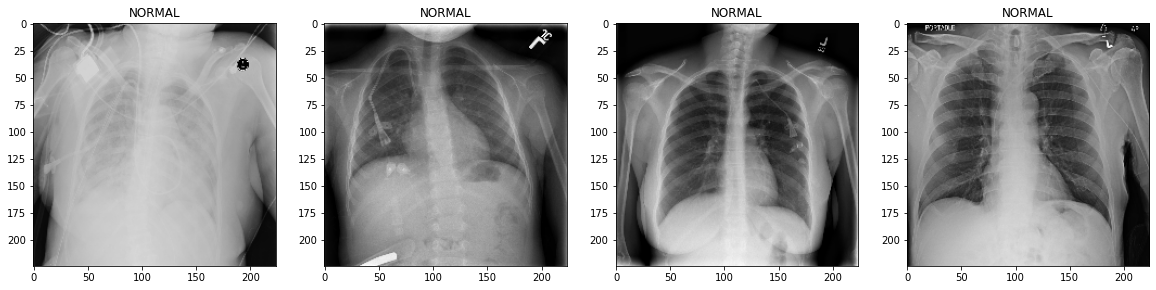

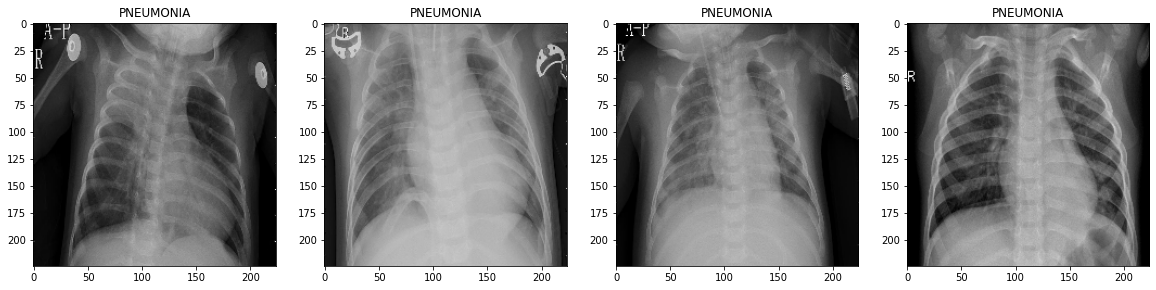

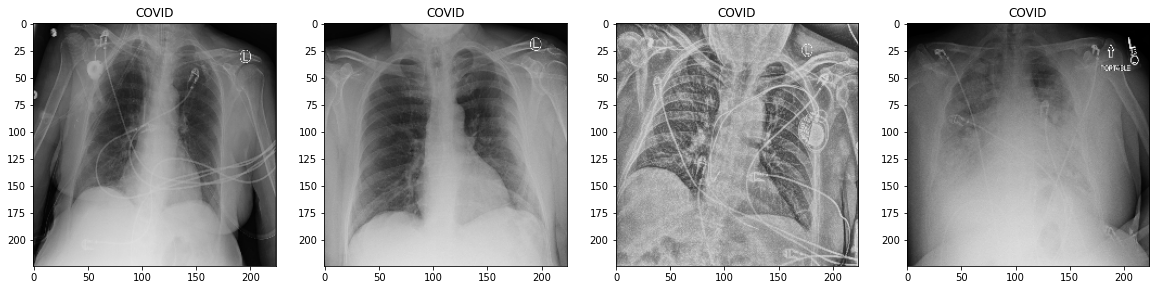

In [ ]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_path_map[img_path_map['label']=="NORMAL"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="PNEUMONIA"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="COVID"].iloc[0:4])

%matplotlib inline

In [ ]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_path_map)
print(label_count)

COVID        16690
NORMAL       15773
PNEUMONIA     4273
dtype: int64


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_path_map['path'].to_numpy()
labels = img_path_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

In [ ]:
for train_index, test_index in stratified_sample.split(features, labels):
    X_train, test_X = features[train_index], features[test_index]
    y_train, test_y = labels[train_index], labels[test_index]
    
half_size = np.int64(len(test_X) / 2)
X_test, y_test = test_X[0:half_size], test_y[0:half_size]
X_val, y_val = test_X[half_size:], test_y[half_size:]

In [ ]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

test_map = pd.DataFrame()
test_map['path'], test_map['label'] = X_test, y_test

val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [ ]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} test size'.format(X_test.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 29388 train size
> 3674 test size
> 3674 val size


In [ ]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("COVID", "NORMAL","PNEUMONIA")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['COVID', 'NORMAL', 'PNEUMONIA']


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [ ]:
batch_size = 64

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [ ]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 29388 validated image filenames belonging to 3 classes.
> label count for train set


COVID        13352
NORMAL       12618
PNEUMONIA     3418
dtype: int64

In [ ]:
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 3674 validated image filenames belonging to 3 classes.
> label count for test set


COVID        1658
NORMAL       1568
PNEUMONIA     448
dtype: int64

In [ ]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 3674 validated image filenames belonging to 3 classes.
> label count for val set


COVID        1680
NORMAL       1587
PNEUMONIA     407
dtype: int64

In [ ]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


## **Building Models**

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import BatchNormalization, InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 3 classes


In [ ]:
def FCLayers(baseModel, fine_tune=0):
    # baseModel.trainable = True
    if fine_tune > 0:
        for layer in baseModel.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in baseModel.layers:
            layer.trainable = False

    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    
    return model

##**CNN Model**

In [ ]:
def CNN_Model(shape,n_classes):
    cnn=Sequential()
    
    #Image Feature Extraction:(Block: 1 - Block: 3)
    #Block-1
    cnn.add(Conv2D(16, (3, 3), activation="relu", input_shape=shape))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    cnn.add(Conv2D(16, (3, 3), activation="relu", input_shape=shape))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))

    #Block-2
    cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=shape))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=shape))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    
    #Block-3
    cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=shape))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=shape))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))

    #Final Layer(Classification/prediction)
    cnn.add(Flatten())
    cnn.add(Dense(activation = 'relu', units = 512))
    # cnn.add(Dropout(0.2))
    cnn.add(Dense(activation = 'relu', units = 128))
    out_put=cnn.add(Dense(n_classes, activation='softmax'))
    
    return cnn

def load_CNN_Model():
    input_shape = (224, 224, 3)
  
    model = CNN_Model(input_shape, n_classes)

    return model

load_CNN_Model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

## **DenseNet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121

def load_DenseNet121():
    input_tensor = Input(shape=input_shape)
    baseModel = DenseNet121(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    model = FCLayers(baseModel)
    return model

load_DenseNet121().summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

##**VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

def load_VGG16():
    input_tensor = Input(shape=input_shape)
    baseModel = VGG16(pooling='avg',
                      # pooling='max',
                      weights='imagenet',
                      include_top=False, 
                      input_tensor=input_tensor)

    model = FCLayers(baseModel)
    return model

load_VGG16().summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## **Call Backs**

In [ ]:
def getMetrics(type_):
    if type_ == 'accuracy':
        return 'accuracy'
    if type_ == 'loss':
        return 'loss'
    if type_ == 'val_accuracy':
        return 'val_accuracy'
    if type_ == 'val_loss':
        return 'val_loss'

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 120
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics('accuracy')) is not None and logs.get(getMetrics('accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics('val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath ='/content/drive/MyDrive/Colab Notebooks/' + name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics('val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             tensorboard_callback,
             lr_plat
            ]

CNN_callbacks = getCallbacks('CNN')
VGG16_callbacks = getCallbacks('VGG16')
DenseNet121_callbacks = getCallbacks('DenseNet121')

## **Compile** and **Fit Model**

In [ ]:
def CompileModel(name, model):
    if name == 'CNN':
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    else:
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):
    if name == 'CNN':
        callbacks_ = CNN_callbacks
    elif name == 'DenseNet121':
        callbacks_ = DenseNet121_callbacks
    else:
        callbacks_ = VGG16_callbacks
        
    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/' + name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics("val_accuracy")][-5:])

    final_loss = history.history[getMetrics("val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics('loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics('loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics('accuracy')][index]
    train_loss = history.history[getMetrics('loss')][index]
    
    val_accuracy = history.history[getMetrics('val_accuracy')][index]
    val_loss = history.history[getMetrics('val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [ ]:
def BuildModel(name):
    if name == 'CNN':
        prepared_model = load_CNN_Model() 
    elif name == 'VGG16':
        prepared_model = load_VGG16()
    else :
        prepared_model = load_DenseNet121()  

    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

## **Training CNN Model**

In [ ]:
c_compiled_model = BuildModel('CNN')
c_model, c_history = FitModel(c_compiled_model, 'CNN')

## **Training DenseNet121**

In [ ]:
d_compiled_model = BuildModel('DenseNet121')
d_model, d_history = FitModel(d_compiled_model, 'DenseNet121')

In [ ]:
d_compiled_model = BuildModel('DenseNet121')
d_compiled_model.load_weights('/content/drive/MyDrive/Colab Notebooks/Bản sao của DenseNet121_Weights.h5')
d_model, d_history = FitModel(d_compiled_model, 'DenseNet121')

## **Training VGG16**

In [ ]:
v_compiled_model = BuildModel('VGG16')
v_model, v_history = FitModel(v_compiled_model, 'VGG16')

In [ ]:
v_compiled_model = BuildModel('VGG16')
v_compiled_model.load_weights('/content/drive/MyDrive/Colab Notebooks/VGG16_Weights.h5')
v_model, v_history = FitModel(v_compiled_model, 'VGG16')

368/367 [==============================] - ETA: -1s - loss: 0.5024 - accuracy: 0.7936
Epoch 3: val_loss did not improve from 0.45921
367/367 [==============================] - 739s 2s/step - loss: 0.5024 - accuracy: 0.7936 - val_loss: 0.4605 - val_accuracy: 0.8196 - lr: 2.6000e-05
Epoch 4/120
368/367 [==============================] - ETA: -1s - loss: 0.5051 - accuracy: 0.7925
Epoch 4: val_loss did not improve from 0.45921
367/367 [==============================] - 788s 2s/step - loss: 0.5051 - accuracy: 0.7925 - val_loss: 0.4598 - val_accuracy: 0.8176 - lr: 3.4000e-05
Epoch 5/120
368/367 [==============================] - ETA: -1s - loss: 0.5004 - accuracy: 0.7954
Epoch 5: val_loss did not improve from 0.45921
Restoring model weights from the end of the best epoch: 2.
367/367 [==============================] - 723s 2s/step - loss: 0.5004 - accuracy: 0.7954 - val_loss: 0.4595 - val_accuracy: 0.8169 - lr: 4.2000e-05
Epoch 5: early stopping


---------------------------------------------

## **Model Evaluation on the TestSet**

In [ ]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int64(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [ ]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [ ]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics('loss')]) - (patience + 1))
    print('Best Epochs: ', index + 20)
    
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    train_accuracy = history.history['accuracy'][index]
    train_loss = history.history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)
    
    print('---'*15) 
    print(name)
    print('> Accuracy on train:',train_accuracy, 
          '\tLoss on train:',train_loss)
    
    print('> Accuracy on test:',test_accuracy,
          '\tLoss on test:',test_loss)
    
    print('---'*15)
    print('> predicting test')
    print('---'*15)
    
    printResults(name, model)

## **CNN Model Results**

In [ ]:
model_summary(g_model, g_history, 'CNN')

## **VGG16 Results**

Best Epochs:  21
58/58 [==============================] - 105s 2s/step - loss: 0.4665 - accuracy: 0.8193


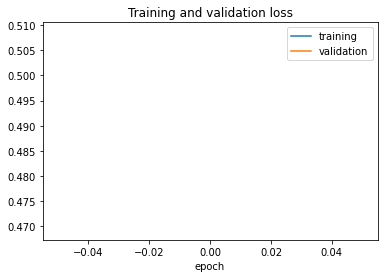

<Figure size 432x288 with 0 Axes>

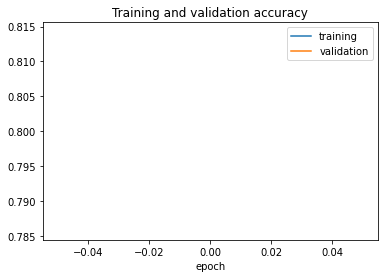

---------------------------------------------
VGG16
> Accuracy on train: 0.7895318865776062 	Loss on train: 0.5055070519447327
> Accuracy on test: 0.8192705512046814 	Loss on test: 0.46650391817092896
---------------------------------------------
> predicting test
---------------------------------------------
58/58 [==============================] - 90s 2s/step


<Figure size 432x288 with 0 Axes>

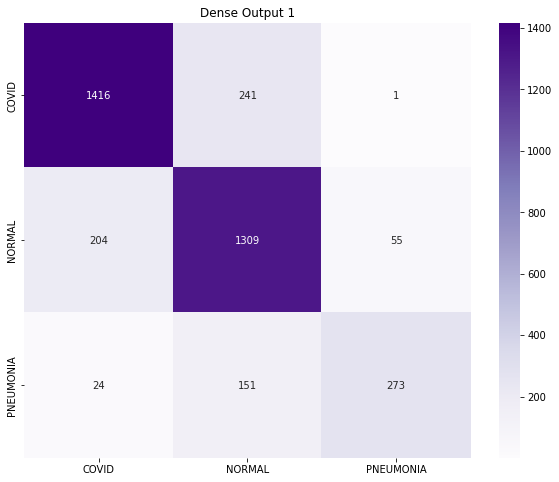

.............................................
> Correct Predictions: 2998
> Wrong Predictions: 676
.............................................
              precision    recall  f1-score   support

       COVID       0.86      0.85      0.86      1658
      NORMAL       0.77      0.83      0.80      1568
   PNEUMONIA       0.83      0.61      0.70       448

    accuracy                           0.82      3674
   macro avg       0.82      0.77      0.79      3674
weighted avg       0.82      0.82      0.81      3674



In [ ]:
model_summary(v_model, v_history, 'VGG16')

## **DenseNet121 Results**

Best Epochs:  20
58/58 [==============================] - 95s 2s/step - loss: 0.0627 - accuracy: 0.9793


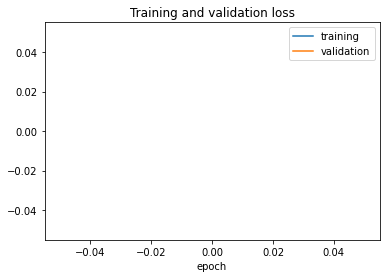

<Figure size 432x288 with 0 Axes>

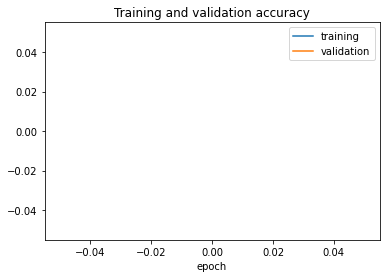

---------------------------------------------
DenseNet121
> Accuracy on train: 0.9847659468650818 	Loss on train: 0.04455244168639183
> Accuracy on test: 0.9793140888214111 	Loss on test: 0.06267082691192627
---------------------------------------------
> predicting test
---------------------------------------------
58/58 [==============================] - 82s 1s/step


<Figure size 432x288 with 0 Axes>

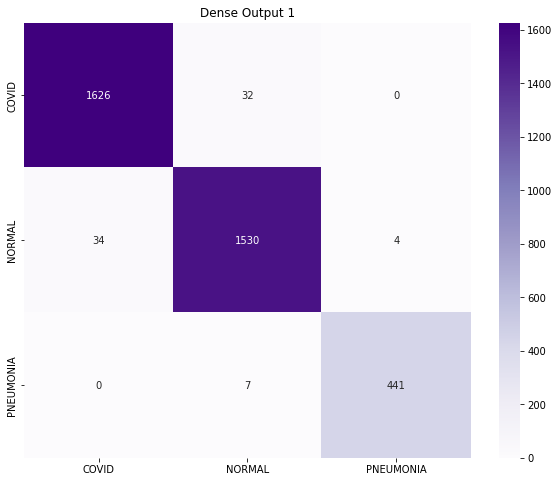

.............................................
> Correct Predictions: 3597
> Wrong Predictions: 77
.............................................
              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98      1658
      NORMAL       0.98      0.98      0.98      1568
   PNEUMONIA       0.99      0.98      0.99       448

    accuracy                           0.98      3674
   macro avg       0.98      0.98      0.98      3674
weighted avg       0.98      0.98      0.98      3674



In [ ]:
model_summary(d_model, d_history, 'DenseNet121')

## **Saving Models**

In [ ]:
from IPython.display import FileLink

In [ ]:
c_model.save('CNN_model.h5')
FileLink(r'./CNN_model.h5')

In [ ]:
v_model.save('VGG16_model.h5')
FileLink(r'./VGG16_model.h5')

In [ ]:
d_model.save('DenseNet121_model.h5')
FileLink(r'./DenseNet121_model.h5')

## **Deployed model**

+ **Models**: DenseNet121
+ **Size**: 85.9 MB
+ **Build With**: React Native
+ **Supported Versions**: ANDROID, IOS, WEB

In [ ]:
from IPython.display import IFrame
IFrame(src='https://model-tester.web.app/covid_19', width='100%', height=1000)